In [7]:
import pandas 
import numpy as np
import os
import re
import operator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from data import *
from constants import *
from models import *
from solver import *
import matplotlib.pyplot as plt

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [9]:
root = "/mnt/raid/davech2y/3d_captioning/ShapeNetCore_vol/nrrd_256_filter_div_128_solid/"
captions = pandas.read_csv("captions.tablechair.csv").iloc[:200]
visual_contexts = np.load("data/visual_context.npy")
# captions = pandas.read_csv("captions.tablechair_prep.csv")

In [10]:
captions = Caption(captions)
captions.preprocess()
captions.tranform()
captions.sanity_check()

True

In [11]:
train_captions = captions.tranformed_csv.iloc[:100]
valid_captions = captions.tranformed_csv.iloc[100:200].reset_index(drop=True)

In [12]:
###################################################################
#                                                                 #
#                                                                 #
#                  offline training for encoder                   #
#                                                                 #
#                                                                 #
###################################################################

# prepare the dataloader
shape_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
shape_train_ds = ShapeDataset(root, train_captions, shape_transform)
shape_train_dl = DataLoader(shape_train_ds, batch_size=10)
shape_valid_ds = ShapeDataset(root, valid_captions, shape_transform)
shape_valid_dl = DataLoader(shape_valid_ds, batch_size=10)
shape_dl = {
    'train': shape_train_dl,
    'valid': shape_valid_dl
}

# load the pretrained encoder
encoder = Encoder().cuda()
optimizer = optim.SGD(encoder.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
encoder_solver = EncoderSolver(optimizer, criterion)

# training
encoder_solver.train(encoder, shape_dl, 10, 1)

[epoch 1]: train_loss: 0.608318, train_acc: 0.770000, valid_loss: 0.692915, valid_acc: 0.500000, ETA: 1m 10s
[epoch 2]: train_loss: 0.494480, train_acc: 0.960000, valid_loss: 0.690357, valid_acc: 0.600000, ETA: 1m 3s
[epoch 3]: train_loss: 0.449771, train_acc: 0.970000, valid_loss: 0.672931, valid_acc: 0.860000, ETA: 1m 3s
[epoch 4]: train_loss: 0.423377, train_acc: 0.980000, valid_loss: 0.620872, valid_acc: 0.890000, ETA: 0m 49s
[epoch 5]: train_loss: 0.407138, train_acc: 0.990000, valid_loss: 0.553069, valid_acc: 0.940000, ETA: 0m 40s
[epoch 6]: train_loss: 0.391689, train_acc: 0.990000, valid_loss: 0.502988, valid_acc: 0.940000, ETA: 0m 35s
[epoch 7]: train_loss: 0.380997, train_acc: 0.990000, valid_loss: 0.470141, valid_acc: 0.940000, ETA: 0m 28s
[epoch 8]: train_loss: 0.372454, train_acc: 1.000000, valid_loss: 0.452176, valid_acc: 0.930000, ETA: 0m 16s
[epoch 9]: train_loss: 0.366031, train_acc: 1.000000, valid_loss: 0.441257, valid_acc: 0.930000, ETA: 0m 8s
[epoch 10]: train_loss

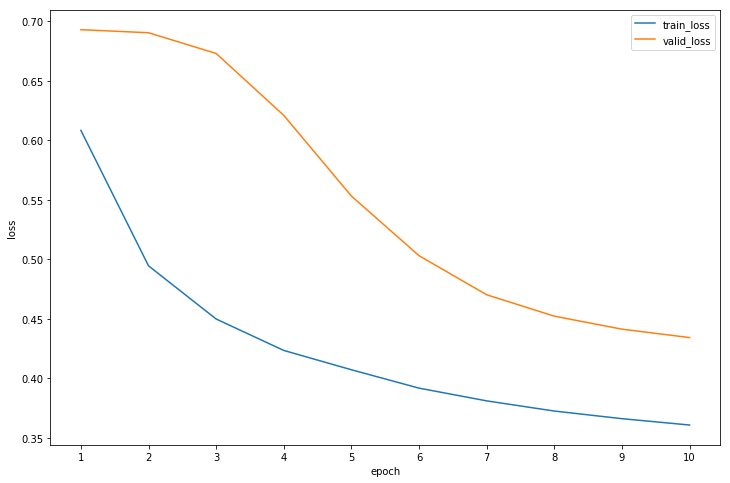

In [21]:
# plot the result
epochs = len(encoder_solver.log.keys())
train_losses = [encoder_solver.log[i]["train_loss"] for i in range(epochs)]
valid_losses = [encoder_solver.log[i]["valid_loss"] for i in range(epochs)]

fig = plt.gcf()
fig.set_size_inches(12,8)
plt.plot(range(1, epochs + 1), train_losses, label="train_loss")
plt.plot(range(1, epochs + 1), valid_losses, label="valid_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.show()

# save
fig.savefig("data/encoder_curve.png")

In [7]:
###################################################################
#                                                                 #
#                                                                 #
#                  offline training for decoder                   #
#              (extracted visual contexts required)               #
#                                                                 #
###################################################################

# caption_train_ds = CaptionDataset(train_context, train_captions.description.values.tolist())
# caption_train_dl = DataLoader(caption_train_ds, batch_size=50, shuffle=False)
# caption_valid_ds = CaptionDataset(valid_context, valid_captions.description.values.tolist())
# caption_valid_dl = DataLoader(caption_valid_ds, batch_size=50, shuffle=False)
# caption_dl = {
#     "train": caption_train_dl,
#     "valid": caption_valid_dl
# }

# input_size = captions.dict_word2idx.__len__() + 1
# hidden_size = 512
# num_layer = 2

# decoder = Decoder(input_size, hidden_size, 2).cuda()
# decoder_solver = DecoderSolver(optim.RMSprop(decoder.parameters(), lr=0.001), nn.CrossEntropyLoss())

# decoder_solver.train(decoder, caption_dl, 10000, 1000)

In [19]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = PipelineDataset(root, train_captions, transform)
train_dl = DataLoader(train_ds, batch_size=50)
valid_ds = PipelineDataset(root, valid_captions, transform)
valid_dl = DataLoader(valid_ds, batch_size=50)
dataloader = {
    'train': train_dl,
    'valid': valid_dl
}

# load the pretrained encoder
encoder = torch.load("data/encoder.pth").cuda()

# define the decoder
input_size = captions.dict_word2idx.__len__() + 1
hidden_size = 512
num_layer = 2
decoder = Decoder(input_size, hidden_size, num_layer).cuda()

# prepare the training parameters
optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
epoch = 1000
verbose = 100

# training
encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion)
encoder_decoder_solver.train(encoder, decoder, dataloader, epoch, verbose)

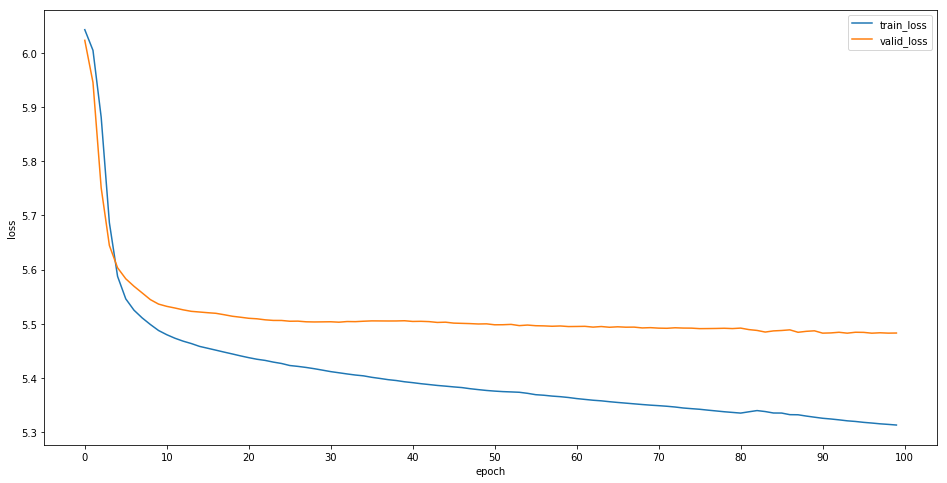

In [13]:
# plot the result
epochs = len(encoder_decoder_solver.log.keys())
train_losses = [encoder_decoder_solver.log[i]["train_loss"] for i in range(epochs)]
valid_losses = [encoder_decoder_solver.log[i]["valid_loss"] for i in range(epochs)]

fig = plt.gcf()
fig.set_size_inches(16,8)
plt.plot(range(epochs), train_losses, label="train_loss")
plt.plot(range(epochs), valid_losses, label="valid_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, epochs + 1, verbose))
plt.legend()
plt.show()

In [6]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "data/encoder_finetuned.pth"
decoder_path = "data/decoder_finetuned.pth"
encoder_decoder = Pipeline(encoder_path, decoder_path)

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = PipelineDataset(root, train_captions, transform)
dataloader = DataLoader(train_ds, batch_size=1)

# caption images
descriptions = []
for image_inputs, _, _ in dataloader:
    image_inputs = Variable(image_inputs).cuda()
    descriptions += encoder_decoder.generate_text(image_inputs, captions.dict_idx2word, 50)

In [14]:
descriptions

['<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
 '<START> four wooden wooden wooden table <END>',
